## Question 1 ##
### Sharpening an image in 4 different ways ###
### a ###
I used the gaussian distribution formula (stated in the 15th slide of 6th lecture) to
make a kernel of size $(2k + 1) \times (2k + 1)$ with a standard deviation of $\sigma$.


In [ ]:
import numpy as np


def generateGaussianKernel(height, width, sigma, mu1, mu2):
    gaussianKernel = np.zeros((height, width))
    for x in range(height):
        for y in range(width):
            gaussianKernel[x, y] = np.exp(- (np.power(x - mu1, 2) + np.power(y - mu2, 2)) / (2 * sigma * sigma)) / (
                    2 * np.pi * sigma * sigma)
    return gaussianKernel

For this image, I used $k = 2$ and $sigma = 1$ which yield in a $ 5 \times 5$ kernel with $\sigma = 1$.
</br>
Then I basically followed the steps of the question and used cv2 for arithmetic calculations as its operations are saturated (preserves the pixels in case of an overflow).
</br>
The result image is obtained for $\alpha = 4$.

### b ###
The process in similar, except that I used Laplacian of Gaussian formula:
</br>
$L o G_{\sigma}=-\frac{1}{\pi \sigma^{4}}\left[1-\frac{x^{2}+y^{2}}{2 \sigma^{2}}\right] e^{-\frac{\left(x^{2}+y^{2}\right)}{2 \sigma^{2}}}$
</br>
For this image, I used $k = 3$ and $sigma = 1$ which yield in a $ 7 \times 7$ kernel with $\sigma = 1$.
</br>
The result image is obtained for $k = 4$.

### c ###
I simply follow the steps in the question

### d ###
I simply follow the steps in the question



<html>
<style>
table, th, td {
  border:1px solid black;
}
</style>
<body>

<h2>values of parameters</h2>

<table style="width:100%">
  <tr>
    <td>sigma in a </td>
    <td>1</td>

  </tr>
  <tr>
    <td>alpha in a</td>
    <td>4</td>

  </tr>
  <tr>
    <td>sigma in b</td>
    <td>1</td>

  </tr>
  <tr>
    <td>k in b</td>
    <td>4</td>

  </tr>
  <tr>
    <td>k in c</td>
    <td>10</td>

  </tr>
   <tr>
    <td>k in d</td>
    <td>0.0000001</td>

  </tr>
</table>


</body>
</html>

## Question 2 ##

### Template Matching ###

Because of the image's large size, I started by reducing its size to 0.125 of the original.


In [ ]:
image = cv2.imread('../images/Greek-ship.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
gray = cv2.resize(gray, None, fx=0.125, fy=0.125)


I did the same for the template:

In [ ]:
template = cv2.imread('../images/patch.png', 0)
template = cv2.resize(template, None, fx=0.125, fy=0.125)

I continued by computing the normalized cross correlation (as described in 27th slide of lecture 8) for the image and the
template:

\begin{equation}
h[m, n]=\frac{\sum_{k, l}(g[k, l]-\bar{g})\left(f[m+k, n+l]-\overline{f_{m, n}}\right)}{\left(\sum_{k, l}(g[k, l]-\bar{g})^{2} \sum_{k, l}\left(f[m+k, n+l]-\overline{f_{m, n}}\right)^{2}\right)^{0.5}}
\end{equation}
( f is represented as the image here and g is the template)

In [ ]:
def templateMatching(img, temp):
    height, width = img.shape
    h, w = temp.shape

    img = np.array(img, dtype="float")
    temp = np.array(temp, dtype="float")

    ncc = np.zeros((height - h, width - w))
    temp = temp - np.mean(temp)

    for y in range(0, height - h):
        for x in range(0, width - w):

            f = img[y: y + h, x: x + w]
            f = f - np.mean(f)

            correlation = np.sum(f * temp)
            norm = np.sqrt((np.sum(f ** 2))) * np.sqrt(np.sum(temp ** 2))

            if norm == 0:
                ncc[y, x] = 0
            else:
                ncc[y, x] = correlation / norm
    return ncc

Next I had this threshold for ncc which indicated the most similarity between the image and the template.
I compute it to be 0.38 by evaluating the results for different values of it. Then I used np.where to distinguish the targeted parts.

In [ ]:
ncc = templateMatching(gray, template)
threshold = 0.38
(locY, locX) = np.where(ncc >= threshold)

This gives me tuples of y and x location of the matches. However, some of these are allocated to the same match. I noticed that they had the same value of x(or roughly the same with at most difference of 2). To avoid having
duplicate ones, I went by sorting out the x locations and got the corresponding indices, hence I applied it to both x locations and y locations:

In [ ]:
sortedIndices = locX.argsort()
locX = locX[sortedIndices[::-1]]
locX = np.flip(locX)
locY = locY[sortedIndices[::-1]]
locY = np.flip(locY)

Now to eliminate the same ones and keep only one of them, I kept the one with the mean value of all the y locations corresponding to that target.

In [ ]:
def detectDistinctOnes(locx, locy):
    distinctOnes = [locx[0]]
    indices = [0]
    rx, ry = [], []
    for i in range(1, len(locx)):
        if locx[i] - distinctOnes[-1] > 2: #for the x locations, I made the ones with the difference of x being more than 2, distinct from one another.
            distinctOnes.append(locx[i])
            indices.append(i)
    indices.append(len(locx) - 1)
    for i in range(1, len(indices)):
        rx.append(locx[int((indices[i] + indices[i - 1]) / 2)])
        ry.append(int(np.average(locy[indices[i - 1]: indices[i]])))
    return rx, ry

locX, locY = detectDistinctOnes(locX, locY)

Finally, I indicated the targeted areas by drawing a rectangle around them in the following way:

In [ ]:
for pt in zip(*(locY, locX)[::-1]):
    cv2.rectangle(image, (pt[0] * 8, pt[1] * 8), (pt[0] * 8 + w * 8, pt[1] * 8 + h * 8), (0, 0, 255), 2)

## Question 3 ##
### Homography and Image Warping ###

To find the coordinates of four corners of each book, I used the code in following link:
https://www.geeksforgeeks.org/displaying-the-coordinates-of-the-points-clicked-on-the-image-using-python-opencv/

and got the following result:

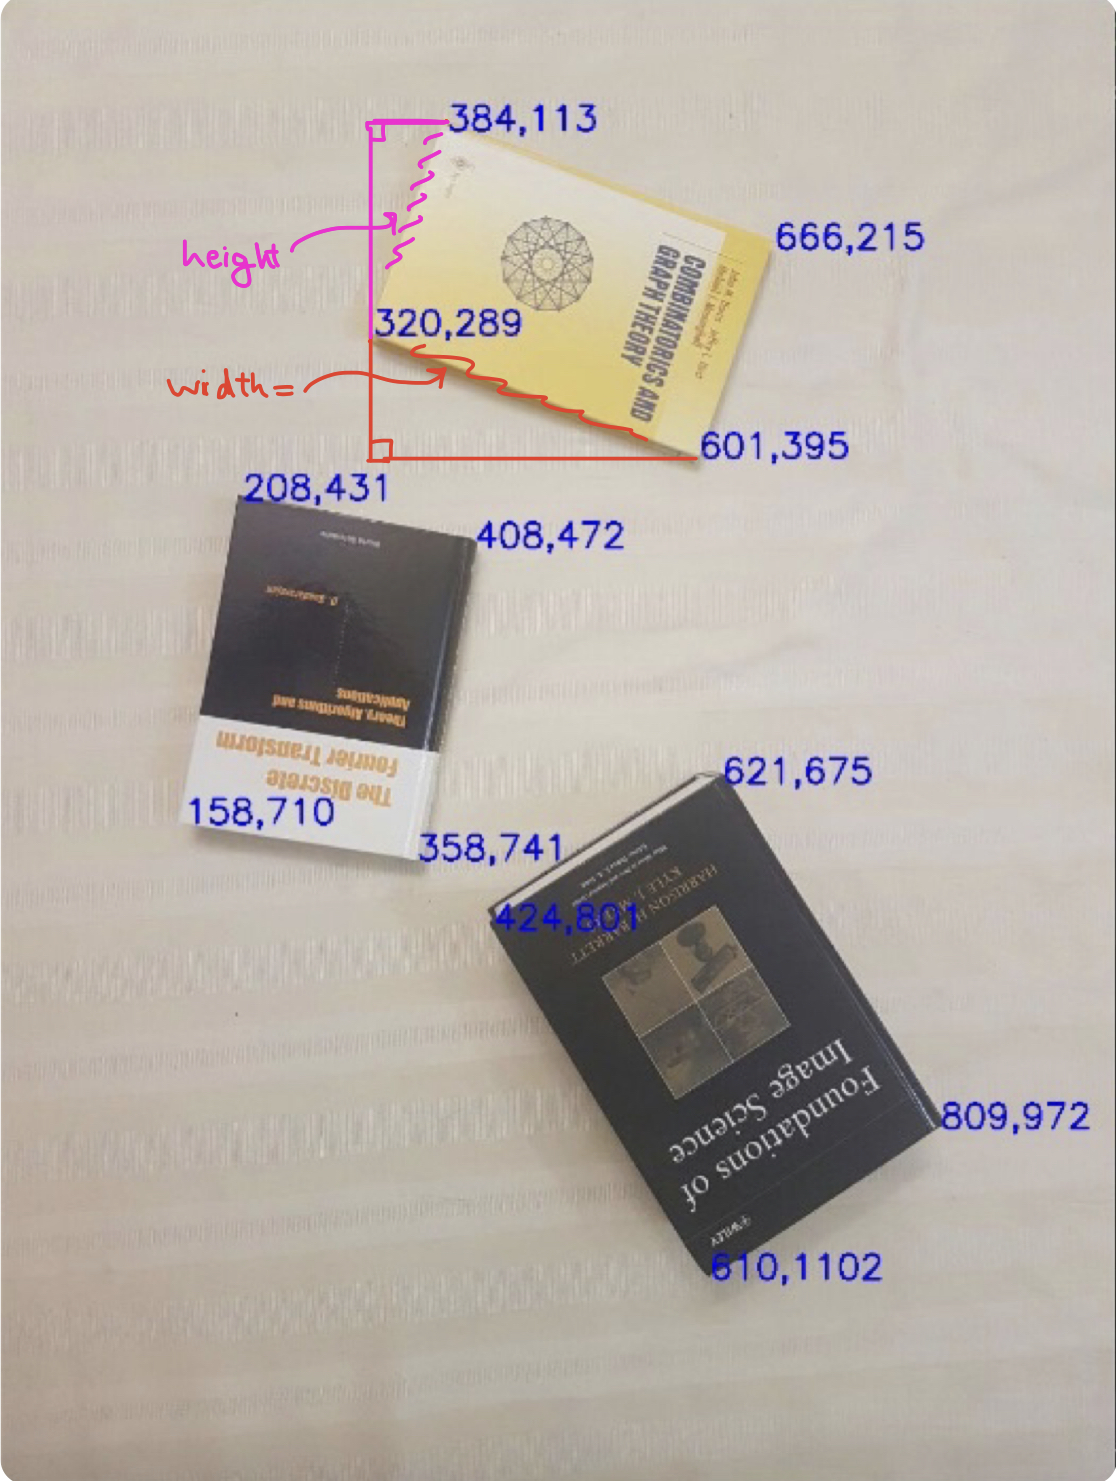

In [5]:
from IPython.display import Image
Image("images/q3-coordinates.jpg")

I continued by computing the width and height of each book and made an array for each of them with the following function:

In [ ]:
def makeArray(x1, y1, x2, y2, x3, y3):
    height = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
    width = np.sqrt((x3 - x2) ** 2 + (y3 - y2) ** 2)
    return np.zeros((int(width), int(height), 3)), width, height

By having the source and destination points, I found the homography between them:

In [ ]:
srcPoints = np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]], dtype=float)
    desPoints = np.array([[0, 0], [height - 1, 0], [0, width - 1], [height - 1, width - 1]], dtype=float)
    h, status = cv2.findHomography(srcPoints, desPoints)

And then warped the image with the function bellow:

In [ ]:
def warp(h, src, dest):
    dh, dw, dc = dest.shape
    hInv = np.linalg.inv(h)
    for j in range(dh):
        for i in range(dw):
            v = np.array([[i], [j], [1]])
            # [[l], [k], [t]] = np.matmul(hInv, v)
            [[l], [k], [t]] = hInv @ v
            l, k = l / t, k / t
            # if 0 <= l < (sh - 1) and 0 <= k < (sw - 1):
            y, x = np.floor(l).astype(int), np.floor(k).astype(int)
            b, a = l - y, k - x
            x1, y1 = x + 1, y + 1
            res = (1 - b) * (1 - a) * src[x, y] + a * (1 - b) * src[x1, y] + b * (1 - a) * src[x, y1] + a * b * src[
                x1, y1]
            dest[j, i] = res
    return dest

Note that I used backward warping (computed the inverse of h and applied it to each position in the destination array) and linear interpolation in order to have the best results.
</br>

Bilinear interpolation:
$f(x+a, y+b)=(1-b) f(x+a, y)+b f(x+a, y+1)$
$f(x+a, y)=(1-a) f(x, y)+a f(x+1, y)$
$f(x+a, y+1)=(1-a) f(x, y+1)+a f(x+1, y+1)$
$f(x+a, y+b)=$
$(1-b)(1-a) f(x, y)+$
$a(1-b) f(x+1, y)+$
$b(1-a) f(x, y+1)+$
$a b f(x+1, y+1)$

In [ ]:
def warp(h, src, dest):
    dh, dw, dc = dest.shape
    hInv = np.linalg.inv(h)
    for j in range(dh):
        for i in range(dw):
            v = np.array([[i], [j], [1]])
            # [[l], [k], [t]] = np.matmul(hInv, v)
            [[l], [k], [t]] = hInv @ v
            l, k = l / t, k / t
            # if 0 <= l < (sh - 1) and 0 <= k < (sw - 1):
            y, x = np.floor(l).astype(int), np.floor(k).astype(int)
            b, a = l - y, k - x
            x1, y1 = x + 1, y + 1
            res = (1 - b) * (1 - a) * src[x, y] + a * (1 - b) * src[x1, y] + b * (1 - a) * src[x, y1] + a * b * src[
                x1, y1]
            dest[j, i] = res
    return dest

## Question 4 ##
### Hybrid Images ###
I used Taylor Swift's image as the far one (what you would see when you look at it from a far distance) and Harry Style's image as the near one.



In [ ]:
near = cv2.imread("../results/res19-near.jpeg")
near = near.astype(float)
height, width, c = near.shape

far = cv2.imread("../results/res20-far.jpg")
far = far.astype(float)


I started by aligning their eyes with each other, so I calculated the corresponding coordinates and then found the scale transformation so that the distance between their eyes is the same.

In [ ]:
x1, y1, x2, y2 = 104, 159, 187, 145
x3, y3, x4, y4 = 117, 179, 186, 166

# Find the scale transformation which maps points from the near one to the far image.
a = (x4 - x3) / (x2 - x1)
b = (y4 - y3) / (y2 - y1)
h = np.array([[a, 0, 0], [0, b, 0], [0, 0, 1]], dtype=float)
[[nx1], [ny1], [t]] = np.dot(h, np.array([[x1], [y1], [1]]))

Furthermore, I moved them both so that their eyes end up in the same coordinate as one another. This also made the images to have the same size.

In [ ]:
nx1, ny1 = int(nx1), int(ny1)
xdiff, ydiff = x3 - nx1, y3 - ny1
near = near[xdiff:, ydiff:, ]
far = cv2.warpPerspective(far, h, (height, width))
far = far[0: width - xdiff, 0: height - ydiff, ]
cv2.imwrite('../results/res21-near.jpg', near)
cv2.imwrite('../results/res22-far.jpg', far)

Then continued by generating their fft with the function bellow.
It simply calculates the fft for the colored img and shifts it ( it also saves the log of its absolute value too)

In [ ]:
def generateFFT(img, name):
    ImgFft = np.fft.fft2(img, axes=(0, 1))
    shiftedImg = np.fft.fftshift(ImgFft)
    amplitude = np.abs(shiftedImg)
    logAmplitude = 20 * np.log(amplitude)
    cv2.imwrite('../results/' + name + '.jpg', logAmplitude)
    return shiftedImg

I used gaussian filter as my highpass filter and laplacian as lowpass ( in here the lowpass filter is simply obtined by subtracting the gaussian filter from 1)
The sigma value for gaussian(far one) is represented by $r$ and it is $s$ for the other one.


In [ ]:
from matplotlib import pyplot as plt


def generateGaussianKernel(height, width, sigma, mu1, mu2):
    gaussianKernel = np.zeros((height, width))
    for x in range(height):
        for y in range(width):
            gaussianKernel[x, y] = np.exp(- (np.power(x - mu1, 2) + np.power(y - mu2, 2)) / (2 * sigma * sigma))
    plt.imshow(gaussianKernel)
    plt.colorbar()
    plt.show()
    return gaussianKernel


def generateLaplacianFilter(height, width, sigma, mu1, mu2):
    laplacianKernel = 1 - generateGaussianKernel(height, width, sigma, mu1, mu2)
    plt.imshow(laplacianKernel)
    plt.colorbar()
    plt.show()
    return laplacianKernel

r, s = 55, 8
gaussianKernel = generateGaussianKernel(height, width, r, int(height / 2), int(width / 2))
laplacianKernel = generateLaplacianFilter(height, width, s, int(height / 2), int(width / 2))



Then I applied filters to each channel of the image (the highpass filter to the far one and the lowpass one to the near image)

In [ ]:
def applyFilter(image, filter, name):
    result = []
    for i in range(0, 3):
        result.insert(0, filter * image[:, :, 2 - i])
    uimg = np.dstack(result)
    mag = np.log(np.abs(uimg))
    cv2.imwrite('../results/' + name + '.jpg', mag)
    return uimg

lowPassed = applyFilter(nearFFT, laplacianKernel, 'res27-lowpassed')
highPassed = applyFilter(farFFT, gaussianKernel, 'res28-highpassed.')

While I am at frequency domain, I combine the images by simply calculating their average.
Then convert it to spatial domain and find the real value of pixels. Another important mehod in this step was scale mehod which
takes the values to be in [0,255]

In [ ]:
def scale(array):
    min, max = array.min(), array.max()
    return ((array - min) * (1 / (max - min) * 255)).astype('uint8')

result = (np.array(lowPassed) + np.array(highPassed)) / 2.0
ishifted = np.fft.ifftshift(result)
final = np.fft.ifft2(ishifted, axes=(0, 1))
final = (np.real(final))

cv2.imwrite('../results/res29.jpg', scale(final))
